In [2]:
from datetime import datetime
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## 2.1 Data Prep
The preperatory phase included transformations to create daily observational data by averaging observations from multiple sensors (weather stations).  The data prepertation here consists of:
* Loading the data
* Creating separate date columns to make the data easier to group w.r.t year and month of observation
* Quantifying missing values

In [3]:
df = pd.read_csv("../../data/weather_by_day_2017_06_03.csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2736 entries, 0 to 2735
Data columns (total 11 columns):
date                  2736 non-null object
maxTemp               2735 non-null float64
minTemp               2736 non-null float64
meanTemp              2735 non-null float64
heatDegDays           2735 non-null float64
coolDegDays           2735 non-null float64
totalRainMM           1208 non-null float64
totalSnowCM           1081 non-null float64
totalPrecipMM         2697 non-null float64
snowOnGroundCM        1201 non-null float64
dirOfMaxGust10sDEG    124 non-null float64
dtypes: float64(10), object(1)
memory usage: 235.2+ KB
None


,date,maxTemp,minTemp,meanTemp,heatDegDays,coolDegDays,totalRainMM,totalSnowCM,totalPrecipMM,snowOnGroundCM,dirOfMaxGust10sDEG
0,2010-01-01,0.0,-9.2,-4.6,22.6,0.0,0.0,15.0,4.9,0.0,NaN
1,2010-01-02,-9.2,-14.1,-11.7,29.7,0.0,0.0,6.0,4.1,15.0,NaN
2,2010-01-03,-5.6,-12.6,-9.1,27.1,0.0,0.0,1.0,1.1,20.0,NaN
3,2010-01-04,-7.5,-11.2,-9.4,27.4,0.0,0.0,1.0,0.5,14.0,NaN
4,2010-01-05,-3.5,-8.9,-6.2,24.2,0.0,0.0,NaN,0.0,15.0,NaN


In [4]:
df['date'] = pd.to_datetime(df['date'])

Add date components as separate columns so we can subset the data more easily

In [5]:
df.loc[:, 'year'] = df['date'].apply(lambda x: x.year)
df.loc[:, 'month'] = df['date'].apply(lambda x: x.month)
df.head()

,date,maxTemp,minTemp,meanTemp,heatDegDays,coolDegDays,totalRainMM,totalSnowCM,totalPrecipMM,snowOnGroundCM,dirOfMaxGust10sDEG,year,month
0,2010-01-01,0.0,-9.2,-4.6,22.6,0.0,0.0,15.0,4.9,0.0,NaN,2010,1
1,2010-01-02,-9.2,-14.1,-11.7,29.7,0.0,0.0,6.0,4.1,15.0,NaN,2010,1
2,2010-01-03,-5.6,-12.6,-9.1,27.1,0.0,0.0,1.0,1.1,20.0,NaN,2010,1
3,2010-01-04,-7.5,-11.2,-9.4,27.4,0.0,0.0,1.0,0.5,14.0,NaN,2010,1
4,2010-01-05,-3.5,-8.9,-6.2,24.2,0.0,0.0,NaN,0.0,15.0,NaN,2010,1


## 2.2 Missing Value Analysis

Identify distribution of missing values

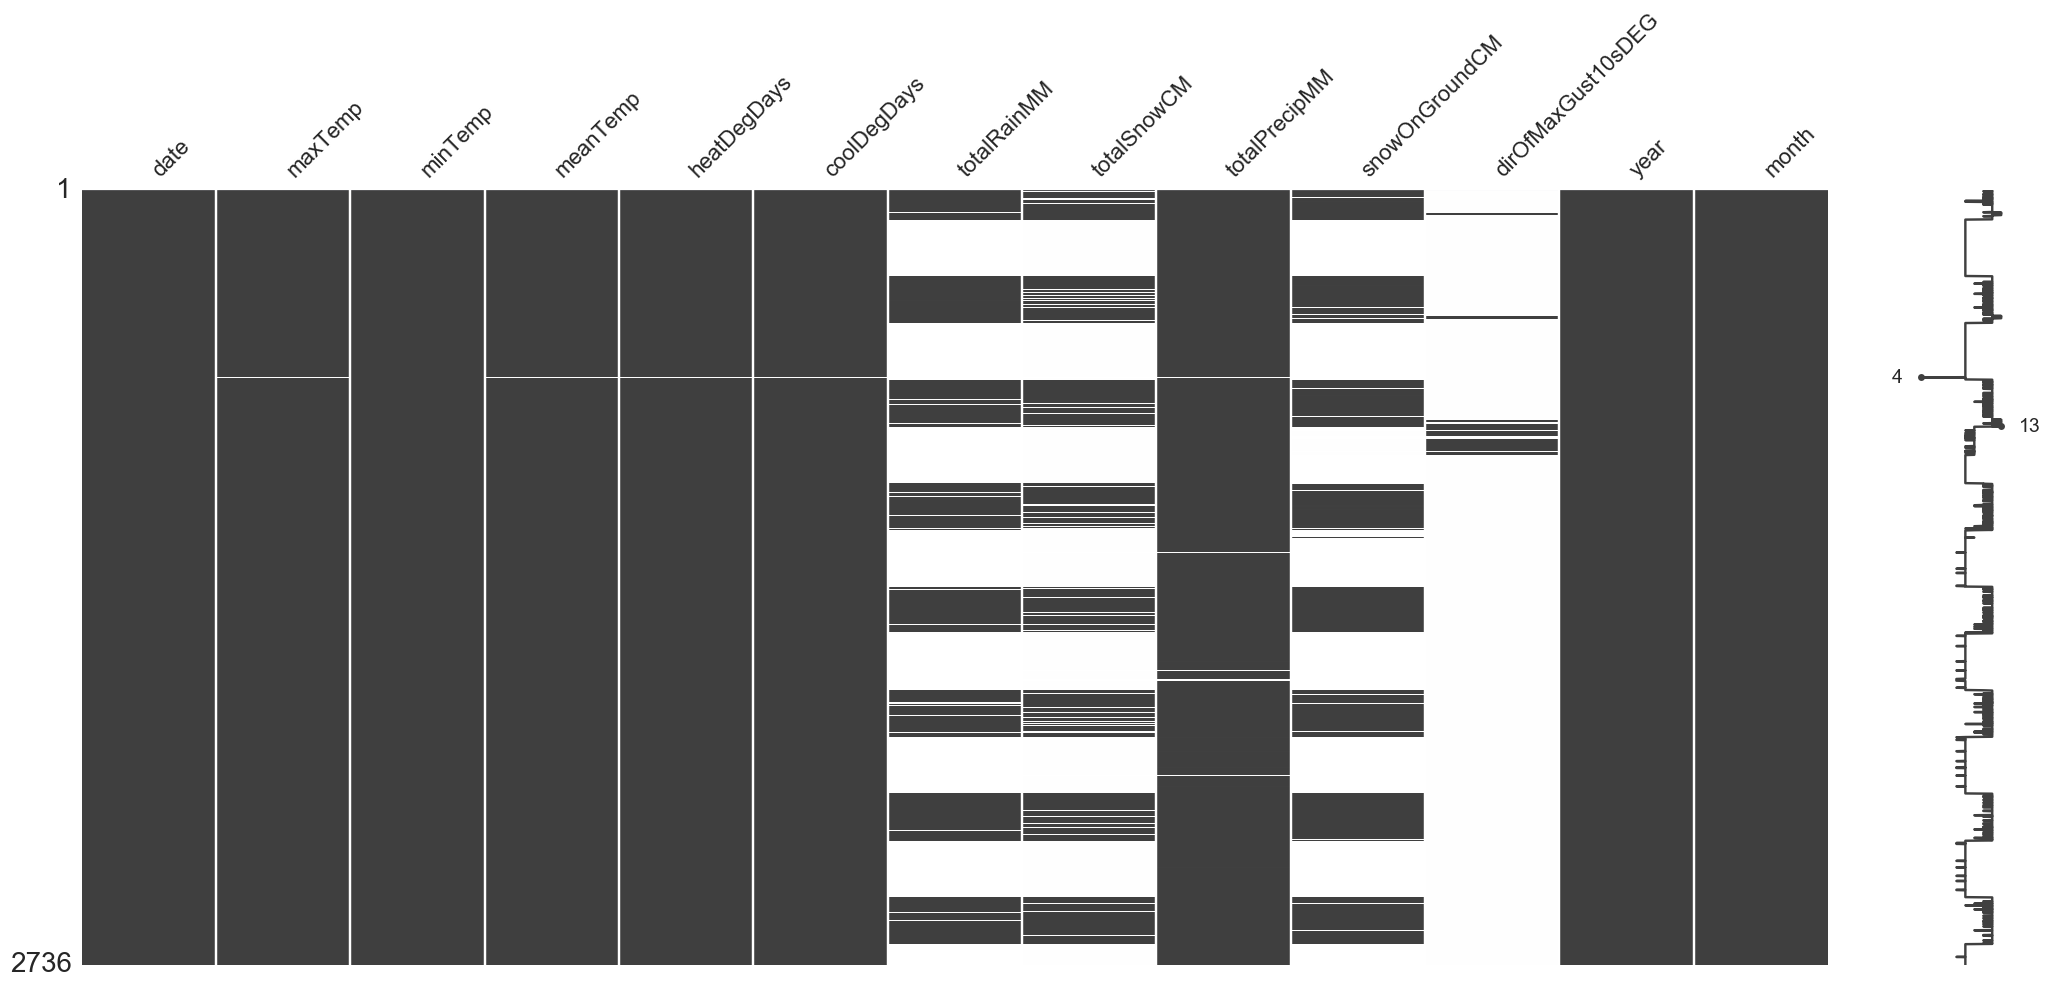

In [6]:
msno.matrix(df.sort_values('date', ascending=True))

There are systematically missing precipitation values but other variables look okay.  Since the data is sorted by the date column, we can see that data is periodically missing.  We can plot the values over time to see where they're missing.  We also need to deal with the fact that there is a single day with only variables (date and minTemp).

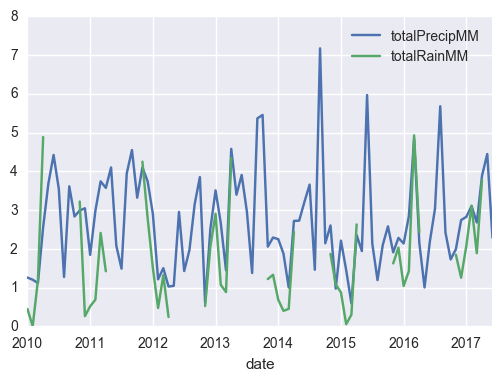

In [7]:
df[['date', 'totalPrecipMM', 'totalRainMM']].set_index('date').resample('1M').plot();

In [8]:
g = df[['month', 'year', 'totalPrecipMM', 'totalRainMM']].groupby(['year', 'month'])[['totalPrecipMM', 'totalRainMM']]
g.apply(lambda x: pd.isnull(x).sum())

totalPrecipMM  totalRainMM
year month                            
2010 1                  0            1
     2                  0            2
     3                  0            2
     4                  0           17
     5                  0           31
     6                  0           30
     7                  0           31
     8                  0           31
     9                  0           30
     10                 0           31
     11                 0            1
     12                 0            1
2011 1                  0            1
     2                  0            1
     3                  0            0
     4                  0           16
     5                  0           31
     6                  0           30
     7                  0           31
     8                  0           31
     9                  0           30
     10                 1           31
     11                 0            2
     12                 0            2
2012 1                  0            2
     2                  0            0
     3                  0            1
     4                  0           18
     5                  0           31
     6                  0           30
...                   ...          ...
2015 1                  1            2
     2                  0            1
     3                  0            1
     4                  2           16
     5                  0           31
     6                  1           30
     7                  2           31
     8                  2           31
     9                  0           30
     10                 1           31
     11                 0            1
     12                 0            1
2016 1                  1            0
     2                  0            0
     3                  0            3
     4                  2           16
     5                  0           31
     6                  1           30
     7                  1           31
     8                  1           31
     9                  1           30
     10                 2           31
     11                 0            2
     12                 0            2
2017 1                  0            1
     2                  0            1
     3                  0            0
     4                  0           18
     5                  1           31
     6                  0           28

[90 rows x 2 columns]

April through October is missing rain measurements year-over-year.  There are a few ways we could handle this:
1. Infer rain values using linear regression.  This may be problematic since we don't have examples of rain for a majority of the months
2. Instead of classifying days as rain/not-rainy we could classify them as very low, low, medium, high, and very high precipitation.  Then we could count the number of high or very high precipitation days
3.  Depending on the relationships present in the data, we may be able to model rain/no-rain as a logistic regression

## 2.3 Multivariate Data Analysis
We'll look at the distributions of each variable simultaneously to evaluate distributions and relationships.  Adding a seasonal indicator will allow us to visualize seasonal weather effects (if any).  Seasonals bounds can be found in [[4]](https://en.wikipedia.org/wiki/Season#Meteorological):

> Spring begins on 1 March, summer on 1 June, autumn on 1 September, and winter on 1 December...

In [40]:
def season(date):
  if date.month == 12 or date.month < 3:
    # December - Feb
    return 'winter'
  elif date.month >= 3 and date.month < 6:
    # March - June
    return 'spring'
  elif date.month >= 6 and date.month < 9:
    # June - Sept
    return 'summer'
  else:
    # Sept - Nov
    return 'fall'

In [41]:
df['season'] = df.date.apply(season)
df.head()

,date,maxTemp,minTemp,meanTemp,heatDegDays,coolDegDays,totalRainMM,totalSnowCM,totalPrecipMM,snowOnGroundCM,dirOfMaxGust10sDEG,year,month,season
0,2010-01-01,0.0,-9.2,-4.6,22.6,0.0,0.0,15.0,4.9,0.0,NaN,2010,1,winter
1,2010-01-02,-9.2,-14.1,-11.7,29.7,0.0,0.0,6.0,4.1,15.0,NaN,2010,1,winter
2,2010-01-03,-5.6,-12.6,-9.1,27.1,0.0,0.0,1.0,1.1,20.0,NaN,2010,1,winter
3,2010-01-04,-7.5,-11.2,-9.4,27.4,0.0,0.0,1.0,0.5,14.0,NaN,2010,1,winter
4,2010-01-05,-3.5,-8.9,-6.2,24.2,0.0,0.0,NaN,0.0,15.0,NaN,2010,1,winter


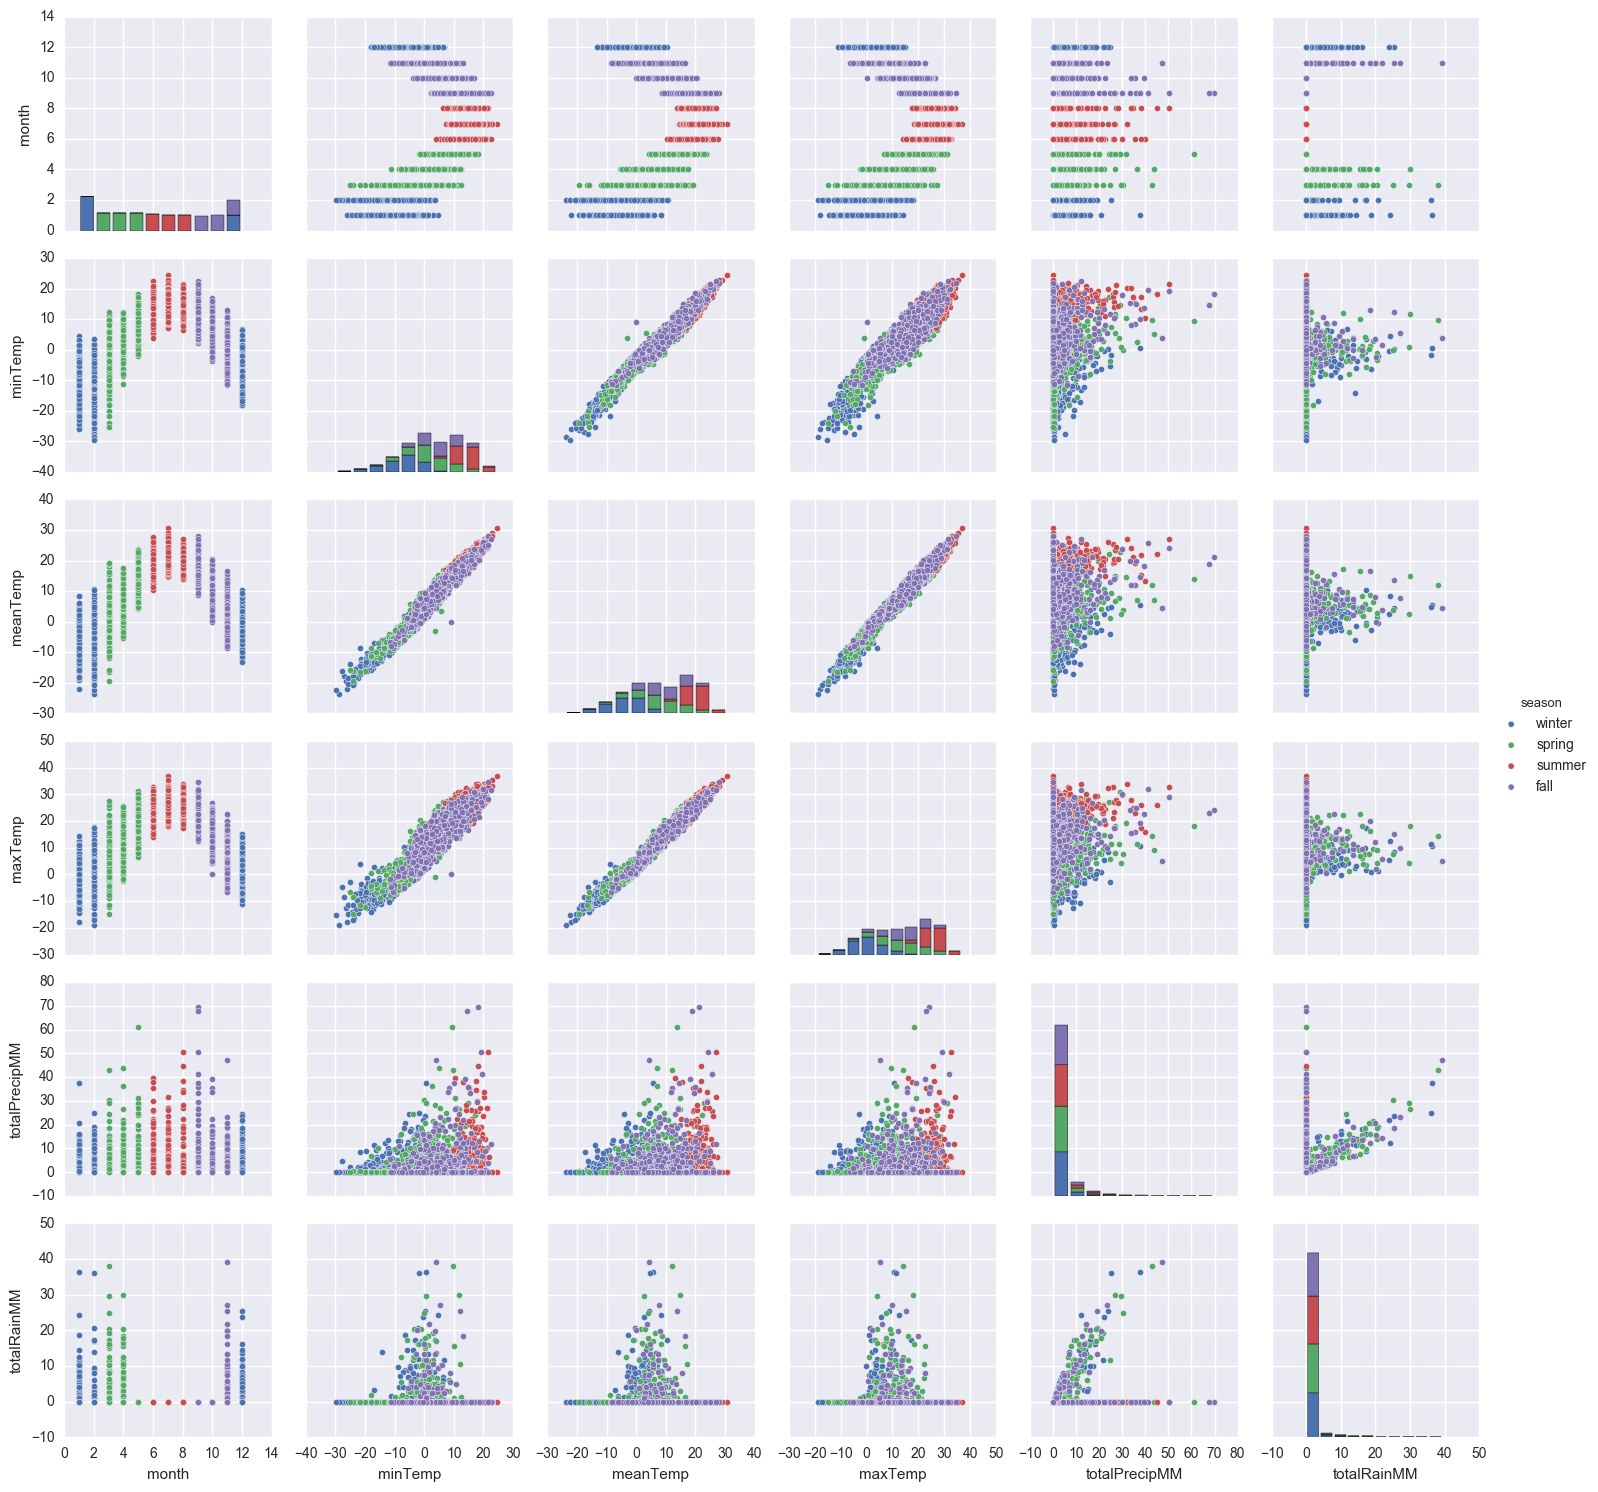

In [59]:
cols = [
  'month',
  'season',
  'minTemp',
  'meanTemp',
  'maxTemp',
  'totalPrecipMM',
  'totalRainMM'
]
sns.pairplot(df[cols].fillna(0), hue='season');

* As you would expect, temperature distributions are bimodal which account for the different seasons and are highly correlated and fall and spring share significant overlap with summer and winter temperatures while summer and winter temperatures share minimal overlap
* Precipitation clearly missing for months of May thru October but may be estimatable from the total precipitation value

Visualize the relationship between winter and summer temperatures

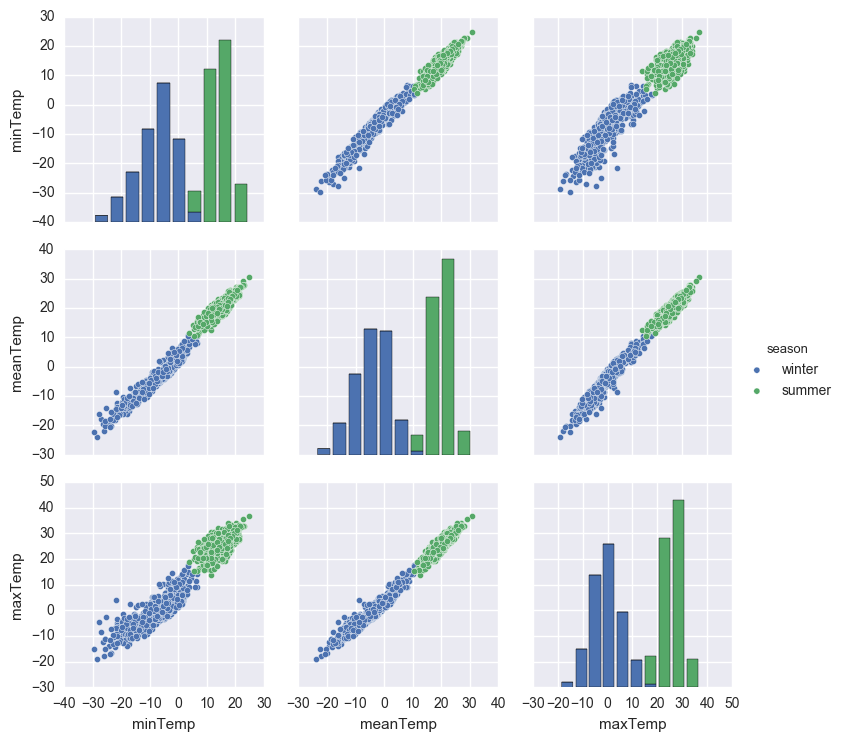

In [63]:
cols = [
#   'month',
  'season',
  'minTemp',
  'meanTemp',
  'maxTemp',
#   'totalPrecipMM',
#   'totalRainMM'
]
sns.pairplot(df.loc[df.season.isin(['winter', 'summer']), cols].fillna(0), hue='season');

* Clear boundary between temperature values - the values clearly natural cluster into two normals

Visualize the relationship between **winter and summer** precipitation and rainfall

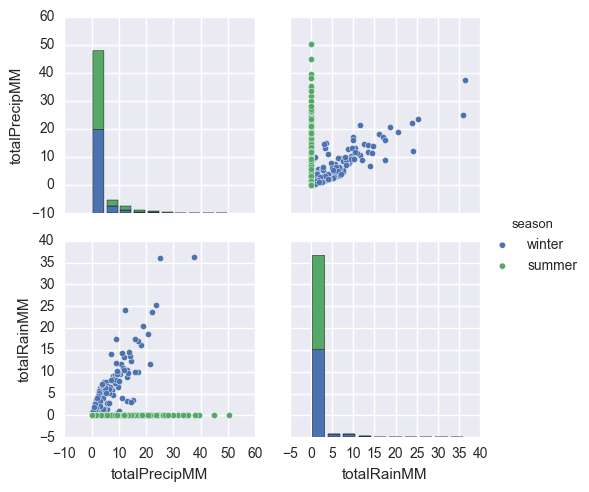

In [67]:
cols = [
#   'month',
  'season',
#   'minTemp',
#   'meanTemp',
#   'maxTemp',
  'totalPrecipMM',
  'totalRainMM'
]
sns.pairplot(df.loc[df.season.isin(['winter', 'summer']), cols].fillna(0), hue='season');

* Missing rain data for the summer

Visualize the relationship between **fall and spring** weather

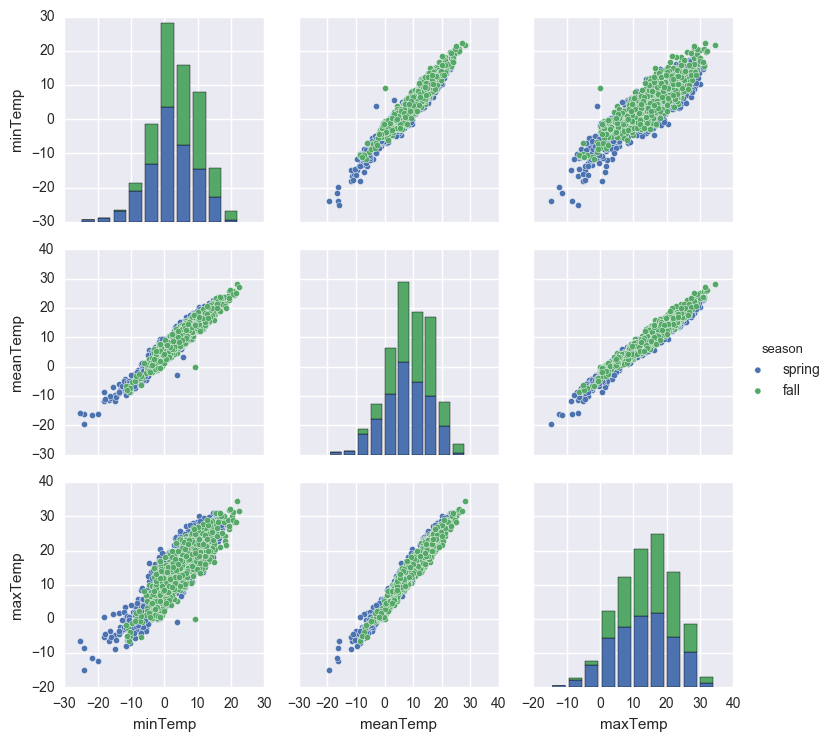

In [58]:
sns.pairplot(df.loc[df.season.isin(['fall', 'spring']), cols].fillna(0), hue='season');

* Significant correlation between temperature distributions for winter and summer
* Significant correlation between temperature distributions for spring and fall

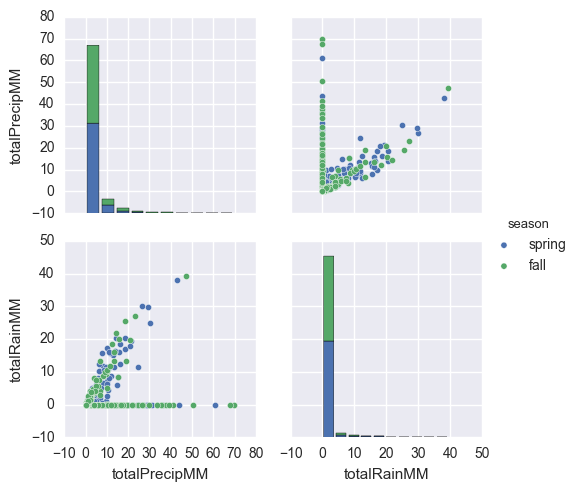

In [68]:
cols = [
#   'month',
  'season',
#   'minTemp',
#   'meanTemp',
#   'maxTemp',
  'totalPrecipMM',
  'totalRainMM'
]
sns.pairplot(df.loc[df.season.isin(['fall', 'spring']), cols].fillna(0), hue='season');

* Significant correlation between rainfall and precipitation data accross seasons
* Since spring and fall contain components of both winter and summer, we can optimistically use the precipitation values to estimate rainfall in the summer and early-fall months

## 2.4 Visualizing Changes Over Time
At this point, we'll only visualize precipitation changes since we are missing significant rainfall data as show above.  In order to more accurately answer the question "has it rained more this year than last", we can use inference to generate rainfall data (i.e. use a predictive model to estimate the rainfall for the missing months).  While we won't further investigate it here (see the next [workbook](#)), it should be noted that inference will be difficult since we've never directly observed the months we are trying to estimate.

The following visualizations describe how precipitation (and thus how rainfall) changes over time.

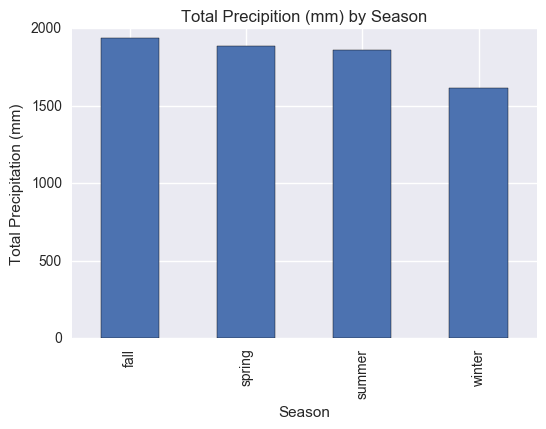

In [70]:
_ = df.groupby('season').totalPrecipMM.sum().plot(kind='bar');
_.set_title("Total Precipition (mm) by Season");
_.set_xlabel("Season");
_.set_ylabel("Total Precipitation (mm)");

Total precipitation stays stable accross seasons.  What about accross years?

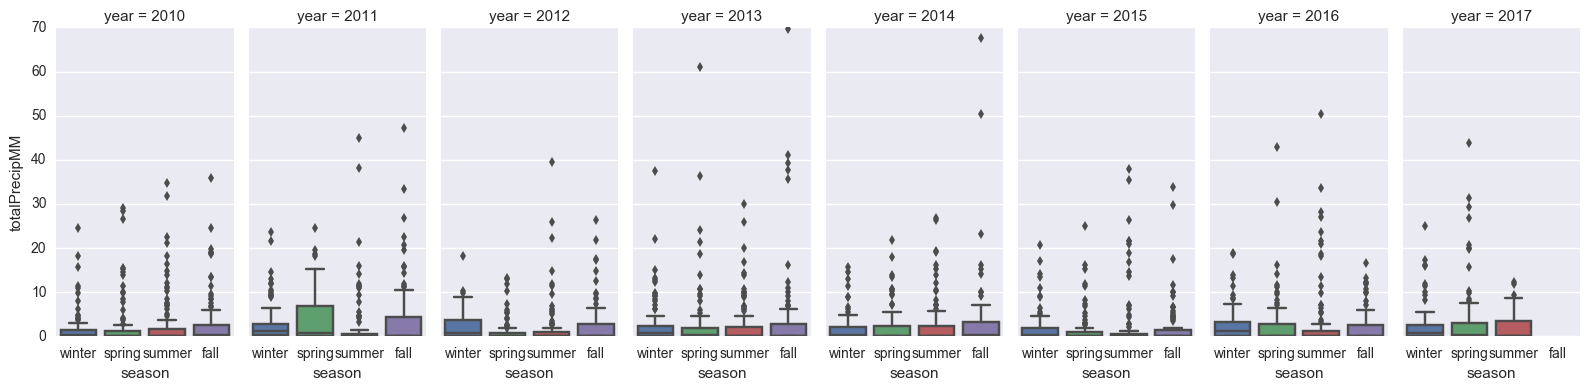

In [71]:
sns.factorplot(x="season", y="totalPrecipMM",
               col="year", data=df, kind="box", size=4, aspect=.5);

It looks like the variation stays roughly constant over time.  We could test this but it's not the focus of this analysis.  We're more interested in changes from 2017 to other years.

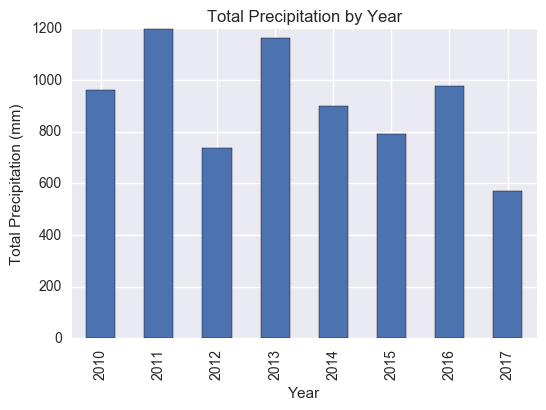

In [72]:
_ = df.groupby('year').totalPrecipMM.sum().plot(kind='bar');
_.set_title("Total Precipitation by Year")
_.set_xlabel("Year");
_.set_ylabel("Total Precipitation (mm)");

We should only consider YTD values since the year isn't done yet

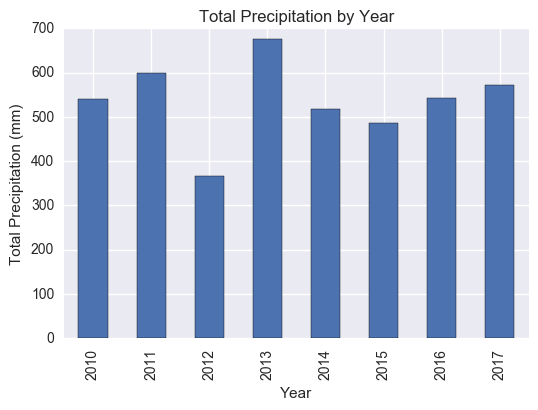

In [88]:
month = datetime.now().month
_ = df[df.month <= month].groupby('year').totalPrecipMM.sum().plot(kind='bar');
_.set_title("Total Precipitation by Year")
_.set_xlabel("Year");
_.set_ylabel("Total Precipitation (mm)");

We can see that there has been an increase in precipitation this year.  In fact, precipitation has been higher this year than it has since 2013 and this year has the third highest precipitatin level in the last seven years.